# Logic Gate Task

This notebook constructs a cTL model to learn several different logic gates without explicit contextualization.

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import time
from IPython.display import clear_output

import tf_utils as tfu

import context_learning as ctl

## Training Strategy

In [3]:
strategy = tfu.strategy.gpu(1)

## Dataset

In [4]:
BATCH_SIZE = 1

In [5]:
x_train = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])

y_train = np.array([
    [0, 0, 0, 1], # AND
    [0, 1, 1, 1], # OR
    [1, 1, 1, 0], # NAND
    [1, 0, 0, 0], # NOR
    [0, 1, 1, 0], # XOR
    [1, 0, 0, 1], # XNOR
    [0, 0, 1, 1], # Custom A
    [0, 1, 0, 1], # Custom B
])[..., np.newaxis]

data_labels = [
    "AND",
    "OR",
    "NAND",
    "NOR",
    "XOR",
    "XNOR",
    "Custom A",
    "Custom B"
]

In [6]:
datasets = [] 
for y in y_train:
    dataset = tf.data.Dataset.from_tensor_slices((x_train, y)).batch(BATCH_SIZE)
    dist_dataset = strategy.experimental_distribute_dataset(dataset)
    datasets.append(dist_dataset)
clear_output() # hide shard warnings

## Model Architecture

In [7]:
def create_model(atr_size=128, switch_threshold=-0.02, num_contexts=8):
    y = x = keras.layers.Input((2,))
    y = keras.layers.Dense(atr_size, activation="relu")(y)
    y = ctl.ContextLayerConvPower(switch_threshold=switch_threshold, num_contexts=num_contexts, verbose=0)(y)
    y = keras.layers.Dense(1, activation="sigmoid")(y)
    model = ctl.ContextModel(x, y, verbose=1)
    model.compile(
        optimizer=keras.optimizers.SGD(1e-1),
        loss=keras.losses.BinaryCrossentropy(from_logits=False))
    return model

## Training

In [8]:
EPOCHS_PER_TASK = 50
REPITIONS = 4

NUM_CONTEXTS = 8
SWITCH_THRESHOLD = -0.02
ATR_SIZE = 128

In [10]:
with strategy.scope():
    train = ctl.make_train_function(eager=False)
    model = create_model(ATR_SIZE, SWITCH_THRESHOLD, NUM_CONTEXTS)
    
    history = {
        "loss": [],
        "context_loss": [],
        "context_delta": [],
    }

    epoch = -1
    for _ in range(REPITIONS):
        for i in np.random.permutation(NUM_CONTEXTS):
            dataset = datasets[i]
            start = epoch + 1
            print("\nDataset:", i)
            for epoch in range(start, epoch+EPOCHS_PER_TASK + 1):
                while model.perform_epoch(epoch):
                    history["loss"].append(0)
                    for batch in dataset:
                        loss = train(strategy, model, batch)
                        history["loss"][-1] += loss
                    print(f"\rEpoch: {epoch}; Task Epoch:{epoch - start + 1}; Dataset: {i}; Loss: {loss}", end="")
                history["context_loss"].append(model.layers[2].context_losses.value())
                history["context_delta"].append(model.layers[2].delta.value())


Dataset: 5
Epoch: 49; Task Epoch:50; Dataset: 5; Loss: 0.029240028932690627
Dataset: 3
Epoch: 99; Task Epoch:50; Dataset: 3; Loss: 0.0034827683120965958
Dataset: 6
Epoch: 149; Task Epoch:50; Dataset: 6; Loss: 0.0059833195991814146
Dataset: 4
Epoch: 199; Task Epoch:50; Dataset: 4; Loss: 0.012394529767334461
Dataset: 1
Epoch: 249; Task Epoch:50; Dataset: 1; Loss: 0.0019366664346307516
Dataset: 7
Epoch: 299; Task Epoch:50; Dataset: 7; Loss: 0.0041246605105698115
Dataset: 0
Epoch: 349; Task Epoch:50; Dataset: 0; Loss: 0.0058430228382349015
Dataset: 2
Epoch: 399; Task Epoch:50; Dataset: 2; Loss: 0.006696965545415878
Dataset: 4
Epoch: 449; Task Epoch:50; Dataset: 4; Loss: 0.0043136351741850385
Dataset: 2
Epoch: 499; Task Epoch:50; Dataset: 2; Loss: 0.0027955088298767805
Dataset: 1
Epoch: 512; Task Epoch:13; Dataset: 1; Loss: 0.00020475925703067333

2022-03-13 04:04:48.407688: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch: 549; Task Epoch:50; Dataset: 1; Loss: 0.00012599311594385654
Dataset: 3
Epoch: 599; Task Epoch:50; Dataset: 3; Loss: 0.00021829480829183012
Dataset: 7
Epoch: 649; Task Epoch:50; Dataset: 7; Loss: 0.0007468700059689581
Dataset: 5
Epoch: 699; Task Epoch:50; Dataset: 5; Loss: 0.0053622899577021625
Dataset: 0
Epoch: 749; Task Epoch:50; Dataset: 0; Loss: 0.0026850870344787836
Dataset: 6
Epoch: 799; Task Epoch:50; Dataset: 6; Loss: 0.0028472947888076305
Dataset: 4
Epoch: 849; Task Epoch:50; Dataset: 4; Loss: 0.0008286113734357059
Dataset: 3
Epoch: 899; Task Epoch:50; Dataset: 3; Loss: 9.263266838388517e-058
Dataset: 2
Epoch: 949; Task Epoch:50; Dataset: 2; Loss: 0.0020356427412480116
Dataset: 6
Epoch: 999; Task Epoch:50; Dataset: 6; Loss: 0.0011824939865618944
Dataset: 7
Epoch: 1049; Task Epoch:50; Dataset: 7; Loss: 0.0009294422343373299
Dataset: 1
Epoch: 1099; Task Epoch:50; Dataset: 1; Loss: 8.532003266736865e-051
Dataset: 5
Epoch: 1102; Task Epoch:3; Dataset: 5; Loss: 0.00361065310

2022-03-13 04:05:18.443106: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch: 1149; Task Epoch:50; Dataset: 5; Loss: 0.0024218158796429634
Dataset: 0
Epoch: 1199; Task Epoch:50; Dataset: 0; Loss: 0.0014206002233549953
Dataset: 6
Epoch: 1249; Task Epoch:50; Dataset: 6; Loss: 0.0009408378391526645
Dataset: 5
Epoch: 1299; Task Epoch:50; Dataset: 5; Loss: 0.0017214809777215123
Dataset: 0
Epoch: 1349; Task Epoch:50; Dataset: 0; Loss: 0.0010710903443396091
Dataset: 4
Epoch: 1399; Task Epoch:50; Dataset: 4; Loss: 0.00039094904786907136
Dataset: 1
Epoch: 1449; Task Epoch:50; Dataset: 1; Loss: 0.00010508009290788323
Dataset: 7
Epoch: 1499; Task Epoch:50; Dataset: 7; Loss: 0.0006868383497931063
Dataset: 3
Epoch: 1549; Task Epoch:50; Dataset: 3; Loss: 6.165126978885382e-05
Dataset: 2
Epoch: 1599; Task Epoch:50; Dataset: 2; Loss: 0.0014920525718480349

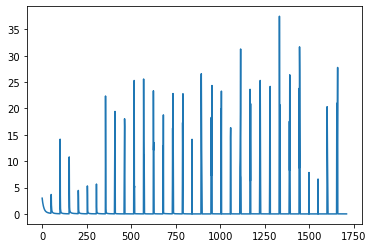

In [11]:
plt.plot(history["loss"])

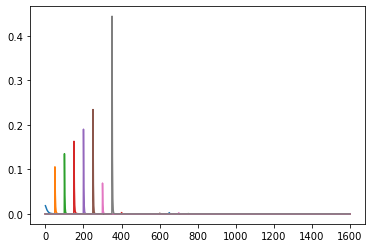

In [12]:
for i, ctx in enumerate(np.array(history["context_loss"]).T):
    plt.plot(ctx)

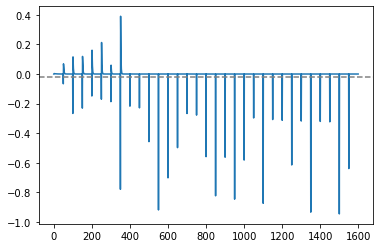

In [13]:
plt.plot(history["context_delta"])
plt.axhline(y=model.layers[2].switch_threshold.value(), color="gray", linestyle="--")

## Evaluation:

The following cell is a rough but quick evaluation of the model, looking for contexts that have fully learned a gate. This method of evaulation should not be used in actual experiments and will be replaced later.

In [16]:
total = 0
for ctx in range(NUM_CONTEXTS):
    model.layers[2].set_context(ctx)
    pred = (model(x_train).numpy() >= 0.5).astype(dtype=np.int32)
    for i in range(len(y_train)):
        if np.all(pred == y_train[i]):
            total += 1
print(f"Accuarcy: {100*total/NUM_CONTEXTS}%")

Accuarcy: 100.0%
